# Breast Cancer prediction using ML

Use scikit-learn's built-in Breast Cancer Wisconsin dataset.  
Alternatively, could go to UCI website: 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic'

In [63]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target # add target var to dataframe


In [64]:
df.shape

(569, 31)

569 total data points and 30 + 1 columns.

Split the data before EDA to prevent data leakage:  
- 70% training
- 15% validation
- 15% training

In [65]:
from sklearn.model_selection import train_test_split

# Create training & test sets
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target'])

# Create validation set from training set
train_df, val_df = train_test_split(
    train_df, test_size=0.25, random_state=42, stratify=train_df['target'])

### EDA

In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 546 to 474
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              455 non-null    float64
 1   mean texture             455 non-null    float64
 2   mean perimeter           455 non-null    float64
 3   mean area                455 non-null    float64
 4   mean smoothness          455 non-null    float64
 5   mean compactness         455 non-null    float64
 6   mean concavity           455 non-null    float64
 7   mean concave points      455 non-null    float64
 8   mean symmetry            455 non-null    float64
 9   mean fractal dimension   455 non-null    float64
 10  radius error             455 non-null    float64
 11  texture error            455 non-null    float64
 12  perimeter error          455 non-null    float64
 13  area error               455 non-null    float64
 14  smoothness error         455 

Null analysis

In [57]:
# Display columns with null counts greater than 0
null_counts = train_df.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


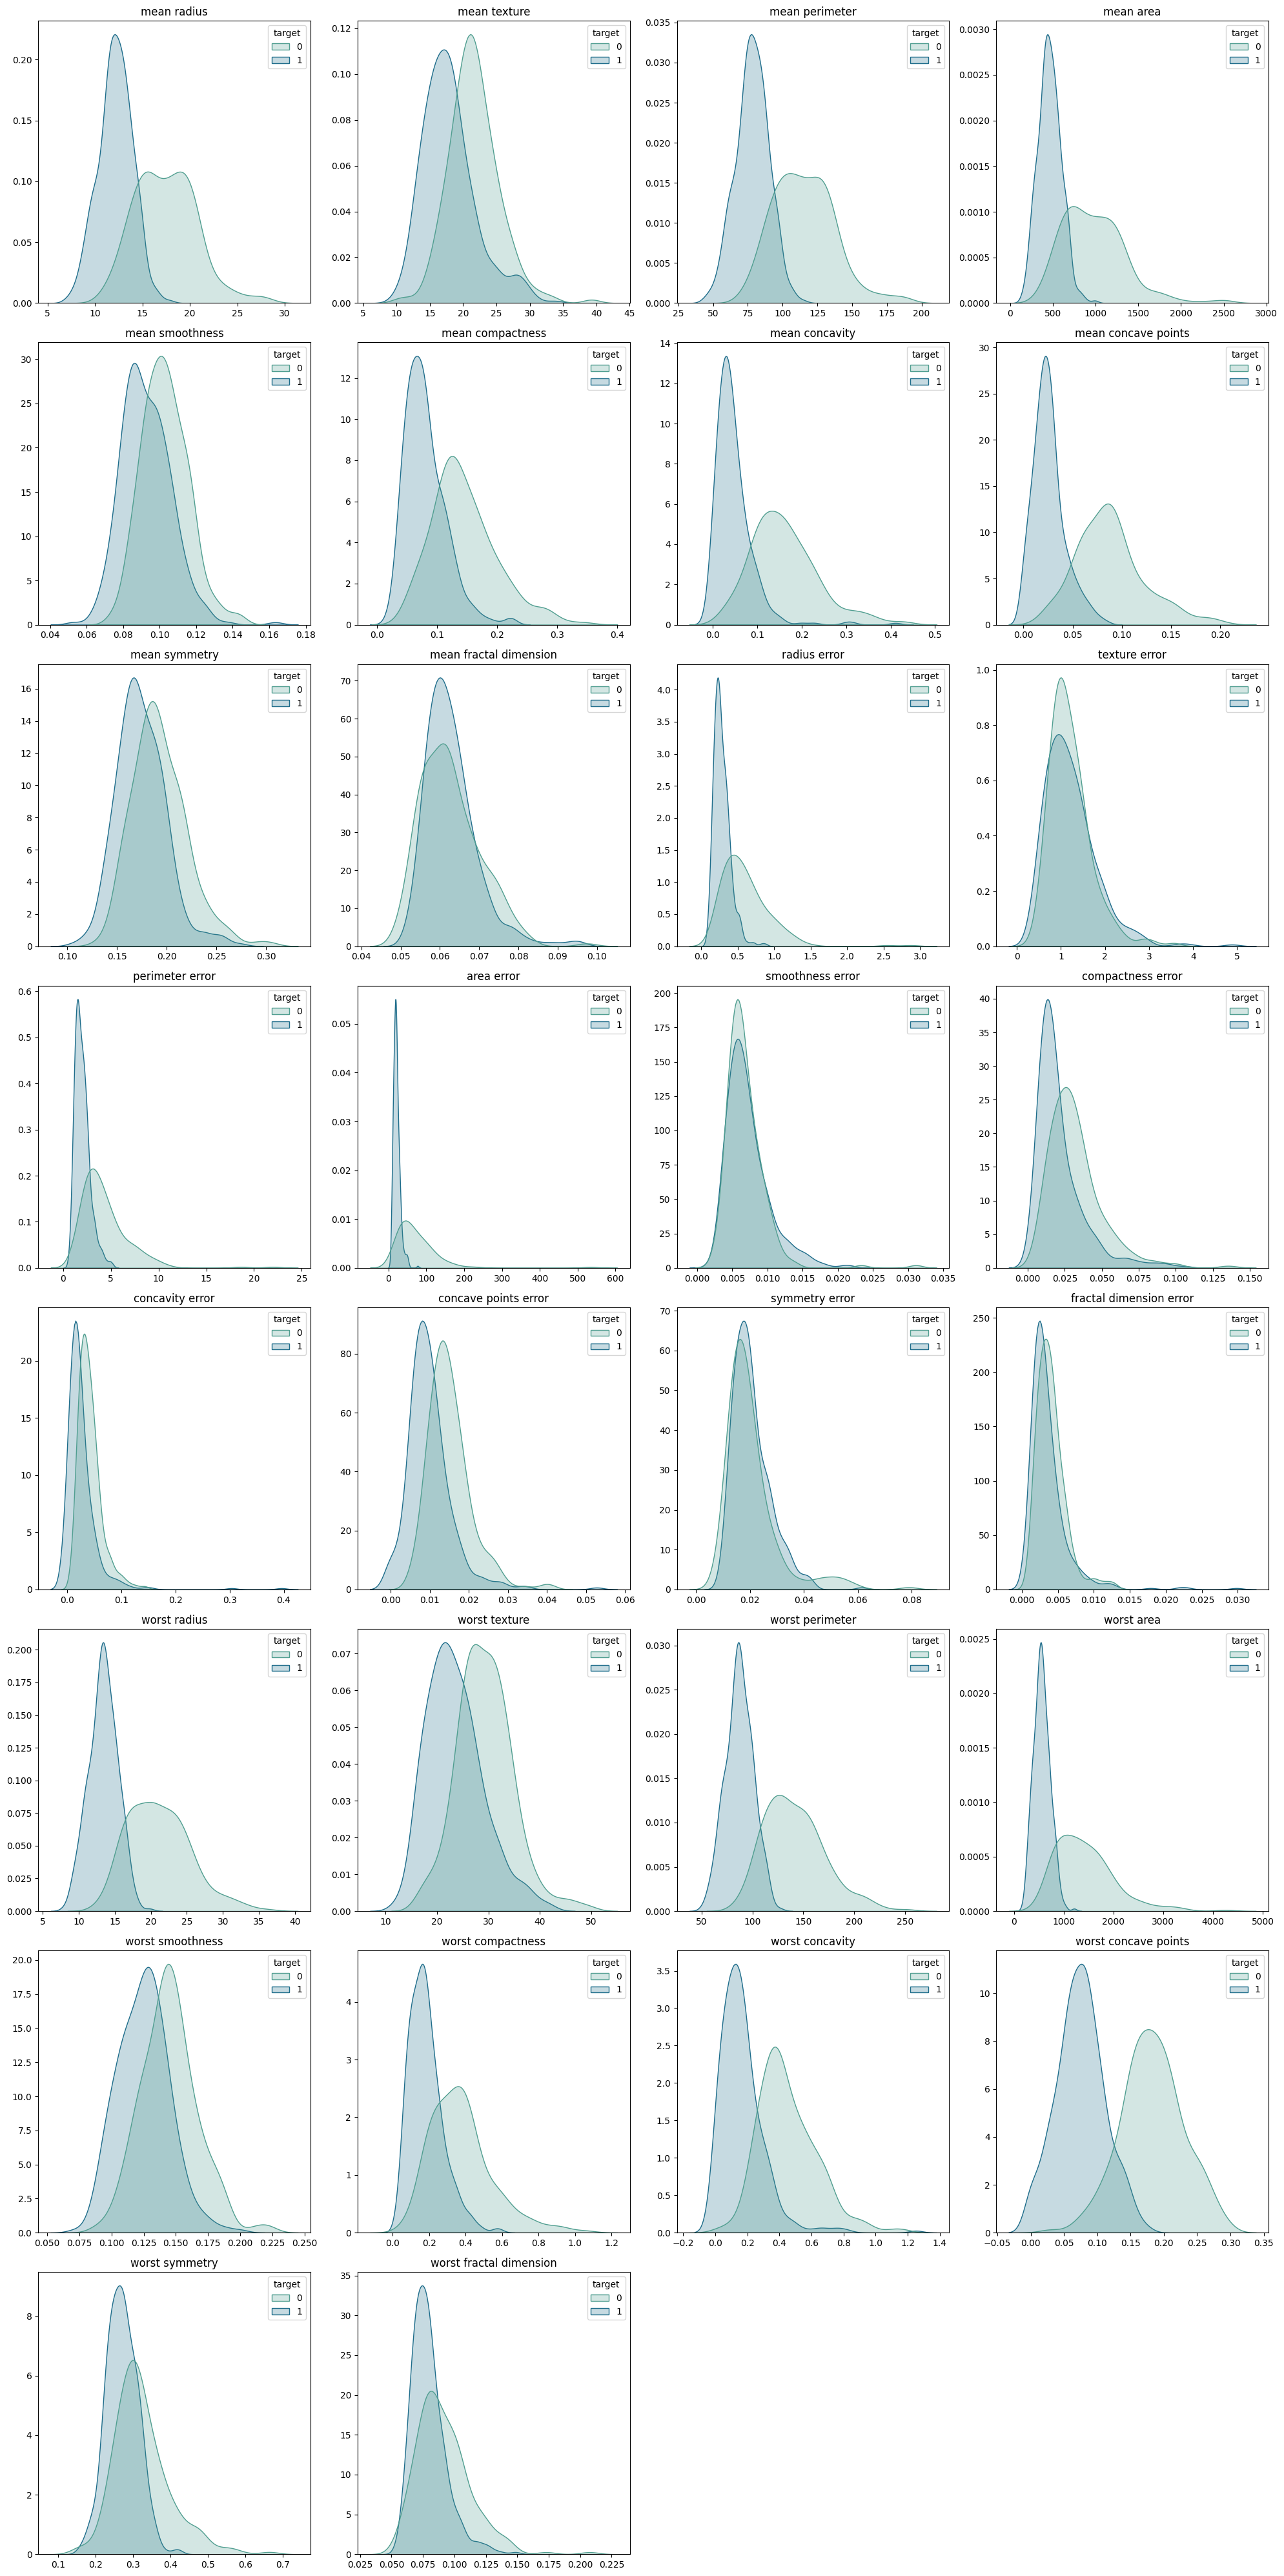

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Density plots for all features
features = train_df.drop(columns='target').columns  # Exclude the target column
cols = 4
rows = len(features) // cols + int(len(features) % cols > 0)

plt.figure(figsize=(20, 5 * rows))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(data=df, x=feature, hue='target', fill=True, common_norm=False, palette='crest')
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Note that PCA would likely be beneficial here due to similar patterns.

Binning:

In [66]:
# Define the binning dictionary
binning_dict = {
    'mean radius': [10, 15],
    'mean texture': [15, 22],
    'mean perimeter': [75, 115],
    'mean area': [500, 1000],
    'mean smoothness': [0.08, 0.11],
    'mean compactness': [0.1, 0.15],
    'mean concavity': [0.1, 0.15],
    'mean concave points': [0.05],
    'perimeter error': [4, 5],
    'worst radius': [15, 20],
    'worst perimeter': [100, 125],
    'worst concave points': [0.1, 0.15]
}

In [67]:
def bin_columns(df, binning_dict):
    """
    Bins specified columns based on the provided binning dictionary.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data to bin.
        binning_dict (dict): A dictionary where keys are column names and values are lists of bin edges.

    Returns:
        pd.DataFrame: A DataFrame with binned columns.
    """
    df_binned = df.copy()
    for column, cutoffs in binning_dict.items():
        bins = [-float('inf')] + cutoffs + [float('inf')]
        df_binned[column] = pd.cut(df_binned[column], bins=bins, labels=False, include_lowest=True)
    return df_binned

In [69]:
# Apply binning to train and test data
train_df_binned = bin_columns(train_df, binning_dict)
val_df_binned = bin_columns(val_df, binning_dict)
test_df_binned = bin_columns(test_df, binning_dict)

Separate features and target variable:

In [70]:
# For training set
X_train = train_df_binned.drop('target', axis=1)
y_train = train_df_binned['target']

# For validation set
X_val = val_df_binned.drop('target', axis=1)
y_val = val_df_binned['target']

# For test set
X_test = test_df_binned.drop('target', axis=1)
y_test = test_df_binned['target']


### Prepare for training

Normalize:

In [71]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Implement PCA:

In [85]:
from sklearn.decomposition import PCA

# Apply PCA after scaling
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

Convert data to pytorch tensors and create dataloaders:

In [86]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert features and targets to tensors
# note that only the x data needs pca transforming
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Update input_dim for the model
input_dim = X_train_tensor.shape[1]

Ensure on GPU with CUDA

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### Logistic Regression

In [88]:
import torch.nn as nn
# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        outputs = self.linear(x)
        return torch.sigmoid(outputs)

In [89]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [90]:
from sklearn.metrics import accuracy_score

# Training loop with validation
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_outputs = []
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
            
            # Collect outputs and labels for accuracy calculation
            all_val_outputs.append(val_outputs.cpu())
            all_val_labels.append(val_labels.cpu())
    avg_val_loss = val_loss / len(val_loader)
    
    # Calculate validation accuracy
    all_val_outputs = torch.cat(all_val_outputs)
    all_val_labels = torch.cat(all_val_labels)
    val_predictions = (all_val_outputs >= 0.5).float()
    val_accuracy = (val_predictions.eq(all_val_labels).sum() / all_val_labels.shape[0]).item()
    
    # Print losses and accuracy every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Epoch [10/100], Training Loss: 0.2378, Validation Loss: 0.2191, Validation Accuracy: 94.74%
Epoch [20/100], Training Loss: 0.1717, Validation Loss: 0.1626, Validation Accuracy: 95.61%
Epoch [30/100], Training Loss: 0.1420, Validation Loss: 0.1399, Validation Accuracy: 96.49%
Epoch [40/100], Training Loss: 0.1265, Validation Loss: 0.1269, Validation Accuracy: 96.49%
Epoch [50/100], Training Loss: 0.1152, Validation Loss: 0.1183, Validation Accuracy: 96.49%
Epoch [60/100], Training Loss: 0.1087, Validation Loss: 0.1121, Validation Accuracy: 96.49%
Epoch [70/100], Training Loss: 0.0999, Validation Loss: 0.1073, Validation Accuracy: 96.49%
Epoch [80/100], Training Loss: 0.0990, Validation Loss: 0.1034, Validation Accuracy: 97.37%
Epoch [90/100], Training Loss: 0.0927, Validation Loss: 0.1002, Validation Accuracy: 97.37%
Epoch [100/100], Training Loss: 0.0909, Validation Loss: 0.0975, Validation Accuracy: 97.37%


### Evaluate

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate on test dataset
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    outputs = model(X_test_tensor)
    predictions = (outputs >= 0.5).float().cpu().numpy()  # Convert to numpy
    true_labels = y_test_tensor.cpu().numpy()

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

Accuracy: 0.965
Precision: 0.986
Recall: 0.958
F1 Score: 0.972

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95        42
         1.0       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



Prioritize true positive rate